In [1]:
import networkx as nx
import scipy.sparse as sp
import numpy as np
import utils
import torch
import torch
from collections import defaultdict
import numpy as np
import time
import json

In [2]:
seed=114514
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.seed_all()

# **Read data**

In [3]:
loader = np.load('split.npy').item()
train_ones = loader['train_ones']
val_ones = loader['val_ones']
val_zeros = loader['val_zeros']
test_ones = loader['test_ones']
test_zeros = loader['test_zeros']
test_edges=test_ones
test_edges_false=test_zeros
print(len(train_ones))
print(np.max(train_ones))
print(np.max(test_ones))

13566
2809
2796


In [4]:
adj_sparse = np.zeros((np.max(train_ones)+1,np.max(train_ones)+1))
for e in train_ones:
    adj_sparse[e[0],e[1]]=1
    adj_sparse[e[1],e[0]]=1
    
adj_sparse = sp.coo_matrix(adj_sparse).tocsr()

lcc = utils.largest_connected_components(adj_sparse)
adj_sparse= adj_sparse[lcc,:][:,lcc]
_N = adj_sparse.shape[0]
print('n',_N)
_Edges=[]
for x in np.column_stack(adj_sparse.nonzero()):
    if not x[0]==x[1]:
        _Edges.append((x[0],x[1]))
_num_of_edges=int(len(_Edges)/2)
print('m',_num_of_edges)

dic=defaultdict(set)
for x in _Edges:
    a1=x[0]
    a2=x[1]
    dic[a1].add(a2)
    dic[a2].add(a1)
    

adj_origin=np.zeros((_N,_N)).astype(int)
for (i,j) in _Edges:
    adj_origin[i][j]=1
    adj_origin[j][i]=1
assert(np.sum(adj_origin==adj_origin.T)==_N*_N)
assert(np.sum(adj_origin)==_num_of_edges*2)

Selecting 1 largest connected components
n 2810
m 6783


# **1.Get link prediction model and embedding**

In [5]:
embedding_dim=128

graphsagemodel=utils.GraphSAGE(_N=_N,_M=_num_of_edges,adj_origin=adj_origin,
                                         adj_dic=dic,embedding_dim=embedding_dim)


# *1.2 Load pretrained model*

In [6]:
graphsagemodel.load_model(path='graphsage.pth',embedding_path='embeddings.npy')

In [7]:
embedding_matrix_numpy=graphsagemodel.embedding_matrix_numpy
link_prediction_model=graphsagemodel.graphsage_link_prediction_from_embedding_one_to_other
predict_adj=utils.evaluate_overlap_torch(_N=_N,
                                                    _num_of_edges=_num_of_edges,
                                                    adj_origin=adj_origin,
                                                    embedding_matrix_numpy=embedding_matrix_numpy,
                                                    link_prediction_from_embedding_one_to_other=link_prediction_model)

2809/2810[(0.70507294, 169, 188), (0.706236, 557, 1973), (0.7066656, 15, 2722), (0.70710826, 2104, 2402), (0.70825166, 349, 2440), (0.7087395, 614, 2598), (0.71208704, 252, 740), (0.713079, 684, 786), (0.71404403, 1434, 2344), (0.71184915, 995, 2280)]
1.0
(2810, 2810)
13566
13566
True Positve:12776, 0.94
False Positve:790, 0.06
True Negative:7881744, 1.00
False Negative:790, 0.00
Positive:0.00
Negative:1.00


In [8]:
metric_embedding=utils.compute_graph_statistics(predict_adj)
metric_origin=utils.compute_graph_statistics(adj_origin)

Values less than or equal to 0 in data. Throwing out 0 or negative values
/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [9]:
for x in metric_origin:
    print('%-25s origin:%17.8f, link_pred:%17.8f'%(x,metric_origin[x],metric_embedding[x]))

d_max                     origin:     240.00000000, link_pred:     241.00000000
d_min                     origin:       1.00000000, link_pred:       0.00000000
d                         origin:       4.82775801, link_pred:       4.82775801
LCC                       origin:    2810.00000000, link_pred:    2802.00000000
wedge_count               origin:  101872.00000000, link_pred:  101066.00000000
claw_count                origin: 3094240.00000000, link_pred: 3188093.00000000
triangle_count            origin:    2814.00000000, link_pred:    2612.00000000
square_count              origin:     517.00000000, link_pred:     545.00000000
power_law_exp             origin:       1.85595899, link_pred:       1.84366819
gini                      origin:       0.48239581, link_pred:       0.47515382
rel_edge_distr_entropy    origin:       0.94070677, link_pred:       0.94233983
clustering_coefficient    origin:       0.00272830, link_pred:       0.00245790
n_components              origin:       

# **2.GAN generate new embeddings**

In [10]:
batch_size=256
noise_dim=16
g_hidden_dim=[32,64,100]
d_hidden_dim=[100,64,32]
lendataloader=20
Diter=5
Giter=1
epoch_numbers=10000
eval_epoch=200


In [11]:
netG = utils.Generator(noise_dim=noise_dim,embedding_dim=embedding_dim, g_hidden_dim=g_hidden_dim,batch_size=batch_size).cuda()

In [12]:
netG.load_state_dict(torch.load('gan_model/bestG_pretrained.pth'))

<All keys matched successfully>

# *2.2.2compute ECDF*

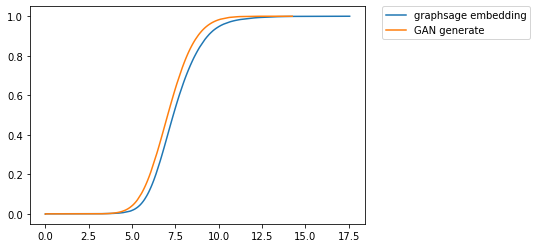

[[0.         0.         0.18309748 0.         1.1138867 ]
 [1.1226885  0.444145   0.0371883  0.89320165 0.        ]
 [0.         0.         0.         1.3897697  2.4473934 ]]
[[0.3656027  0.         0.         0.892687   0.        ]
 [0.10652439 0.6752251  1.5621463  0.1655213  0.        ]
 [0.05632419 1.3437603  1.7646477  0.07964764 0.        ]]
0.018355945
0.013209016
0.01265408


(0.004591993056237698, 2810)

In [13]:
utils.eval_plot(netG,embedding_matrix=embedding_matrix_numpy,noise_dim=16,mmd_beta=0.1)

# **3.Sample**

In [14]:
def edgeoverlap_generate(generate_graph,adj_origin):
    tp=0
    tn=0
    fp=0
    fn=0
    for i in range(_N):
        for j in range(_N):
            if generate_graph[i,j]==1 and adj_origin[i,j]==1:
                tp=tp+1
            if generate_graph[i,j]==0 and adj_origin[i,j]==1:
                fp=fp+1
            if generate_graph[i,j]==1 and adj_origin[i,j]==0:
                fn=fn+1
            if generate_graph[i,j]==0 and adj_origin[i,j]==0:
                tn=tn+1
        print('\r%d/%d'%(i,_N),end="")
    print('\n')
    print('Edge overlap between generate graph and original graph')
    print(generate_graph.shape)
    total_num=_N*_N
    print('True Positve:%d, %.2f'%(tp,tp/(tp+fp)))
    print('False Positve:%d, %.2f'%(fp,fp/(tp+fp)))
    print('True Negative:%d, %.2f'%(tn,tn/(tn+fn)))
    print('False Negative:%d, %.2f'%(fn,fn/(tn+fn)))
    print('Positive:%.2f'%((tp+fp)/total_num))
    print('Negative:%.2f'%((tn+fn)/total_num))
    return tp/(tp+fp)

In [15]:
import os
dirs_generate = 'graph_generate/'
if not os.path.exists(dirs_generate):
    os.makedirs(dirs_generate)
generate_number=5

In [16]:
def save_graph(adj_generate,dirpath):
    edges=[]
    for i in range(_N):
        for j in range(i+1,_N):
            if adj_generate[i][j]==1:
                edges.append((i,j))
    edges=np.array(edges).astype(int)
    np.save(dirpath,edges)

In [17]:
metric_list={}
for idx in range(generate_number):
    noise= torch.randn(_N, noise_dim).cuda()
    generate_data=netG(noise)
    generate_data=generate_data.detach().to('cpu').numpy()
    print('\n',idx,'\n')
    print(generate_data.shape)
    probability_matrix_generate=utils.generate_probability_matrix(_N,generate_data,
                                                                            link_prediction_model)
    _,graphic_seq_generate=utils.evaluate_overlap_torch_generate(_N,_num_of_edges,
                                                                                      probability_matrix_generate)
    generate_graph=utils.revised_Havel_Hakimmi_Algorithm(_N,_num_of_edges,dic,probability_matrix_generate,graphic_seq_generate)
    
    save_graph(generate_graph,'graph_generate/coraml_ourmethod'+str(idx))
    data=utils.compute_graph_statistics(generate_graph)
    data['edge_overlap']=edgeoverlap_generate(generate_graph,adj_origin)
    for x in data:
        try:
            metric_list[x]
        except:
            metric_list[x]=[]
        metric_list[x].append(data[x])



 0 

(2810, 128)
2809/2810[(0.8280811905860901, 1630, 1973), (0.8281784653663635, 726, 1906), (0.8284873366355896, 811, 929), (0.8281857371330261, 1826, 1973), (0.8282559514045715, 200, 2242), (0.8289461135864258, 275, 1419), (0.8287469148635864, 34, 381), (0.8282570242881775, 1054, 2572), (0.828269898891449, 542, 1685), (0.8283506035804749, 1300, 1914)]
 max: (1.0, 2572, 2788) min: (0.8280811905860901, 1630, 1973)
2810
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[240, 125, 67, 62, 61, 61, 54, 50, 46, 44]
[(0, 0), (0, 6), (0, 7), (0, 9), (0, 14), (0, 18), (0, 21), (0, 22), (0, 23), (0, 24)]
[(162, 458), (136, 2572), (130, 723), (126, 2126), (103, 340), (101, 2538), (100, 2478), (84, 2207), (80, 1401), (80, 834)]
[[240, 458], [125, 2572], [67, 723], [62, 2126], [61, 2538], [61, 340], [54, 2478], [50, 2207], [46, 1401], [44, 834]]
[[1, 0], [1, 6], [1, 7], [1, 9], [1, 14], [1, 18], [1, 21], [1, 22], [1, 23], [1, 24]]
 remain_edge:0,x=120173913566.0
0.0
6783


/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


2809/2810

Edge overlap between generate graph and original graph
(2810, 2810)
True Positve:24, 0.00
False Positve:13542, 1.00
True Negative:7868992, 1.00
False Negative:13542, 0.00
Positive:0.00
Negative:1.00

 1 

(2810, 128)
2809/2810[(0.8494345545768738, 118, 2721), (0.8495151400566101, 233, 658), (0.8496720194816589, 1468, 2315), (0.8495765328407288, 737, 2406), (0.8497353792190552, 658, 2479), (0.8505561947822571, 213, 1563), (0.8500344157218933, 737, 2181), (0.8502753376960754, 1773, 2463), (0.850253164768219, 737, 1896), (0.8505911231040955, 698, 1417)]
 max: (1.0, 2470, 2576) min: (0.8494345545768738, 118, 2721)
2810
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[240, 125, 67, 62, 61, 61, 54, 50, 46, 44]
[(0, 1), (0, 4), (0, 5), (0, 6), (0, 7), (0, 9), (0, 10), (0, 11), (0, 13), (0, 16)]
[(151, 737), (146, 488), (132, 2470), (127, 2185), (118, 2221), (113, 1770), (102, 1392), (101, 2389), (98, 1897), (96, 2674)]
[[240, 737], [125, 488], [67, 2470], [62, 2185], [61, 2221], [61, 1770], [54, 13

In [18]:
for x in metric_list:
    metric_mean=np.mean(metric_list[x])
    metric_std=np.std(metric_list[x])
    if x=='edge_overlap':
        print('%-22s generate:%16.8f+-%16.8f'%(x,metric_mean,metric_std))
    else:
        print('%-22s origin:%16.8f, link_pred:%16.8f, generate:%16.8f+-%16.8f'%(x,metric_origin[x],
                                                                                metric_embedding[x],metric_mean,metric_std))

d_max                  origin:    240.00000000, link_pred:    241.00000000, generate:    240.00000000+-      0.00000000
d_min                  origin:      1.00000000, link_pred:      0.00000000, generate:      1.00000000+-      0.00000000
d                      origin:      4.82775801, link_pred:      4.82775801, generate:      4.82775801+-      0.00000000
LCC                    origin:   2810.00000000, link_pred:   2802.00000000, generate:   2515.60000000+-     15.73022568
wedge_count            origin: 101872.00000000, link_pred: 101066.00000000, generate: 101872.00000000+-      0.00000000
claw_count             origin:3094240.00000000, link_pred:3188093.00000000, generate:3094240.00000000+-      0.00000000
triangle_count         origin:   2814.00000000, link_pred:   2612.00000000, generate:   3062.60000000+-    202.23906645
square_count           origin:    517.00000000, link_pred:    545.00000000, generate:   2224.20000000+-    557.16762289
power_law_exp          origin:      1.85